In [1]:
Pkg.activate(".")

UndefVarError: UndefVarError: Pkg not defined

In [2]:
using EBayes
using EBayesDatasets
import JuliaDB
using StatsBase
import DataFrames

Load in the MovieLens dataset. The preprocessing of the data occurs in the [EBayesDatasets.jl](https://github.com/nignatiadis/EBayesDatasets.jl) package.

In [3]:
mv_lens = EBayesDatasets.MovieLens(;n_min_train=3, prop_test=0.1);

┌ Warning: `setcol(t, args::Pair...)` is deprecated, use `transform(t, args...)` instead.
│   caller = EBayesDatasets.MovieLens(::Int64, ::Int64, ::Int64, ::Float64) at movielens.jl:54
└ @ EBayesDatasets /Users/ignatiad/.julia/dev/EBayesDatasets/src/movielens.jl:54
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = EBayesDatasets.MovieLens(::Int64, ::Int64, ::Int64, ::Float64) at movielens.jl:139
└ @ EBayesDatasets /Users/ignatiad/.julia/dev/EBayesDatasets/src/movielens.jl:139


## Pulp Fiction and Urban Justice

In the introduction of the paper we mention the ratings of these two movies, so let us compute these:

In [4]:
movie_titles = JuliaDB.select(mv_lens.movie_df, :title);
length(movie_titles)

12481

In [5]:
pulp_fiction_idx = findall( match.(r"Pulp", movie_titles) .!= nothing)[1]
pulp_fiction = mv_lens.movie_df[pulp_fiction_idx]

(movieId = 296,
 title = "Pulp Fiction (1994)",
 genres = "Comedy|Crime|Drama|Thriller",
 year = 1994,
 test_mean = 4.1734962f0,
 test_n = 60641,
 test_sd = 0.9773011f0,
 train_mean = 4.1809115f0,
 train_n = 6669,
 train_sd = 0.96609414f0,)

In [6]:
# let us average over test and train sets
pulp_fiction_avg = mean( [pulp_fiction[:test_mean], pulp_fiction[:train_mean]],
                    Weights([pulp_fiction[:test_n], pulp_fiction[:train_n]]))
round(Float64(pulp_fiction_avg), digits=1)

4.2

In [7]:
urban_justice_idx = findall( match.(r"Urban Justice", movie_titles) .!= nothing)[1]
urban_justice = mv_lens.movie_df[urban_justice_idx]

(movieId = 66652,
 title = "Urban Justice (2007)",
 genres = "Action",
 year = 2007,
 test_mean = 1.5454545f0,
 test_n = 11,
 test_sd = 0.9862693f0,
 train_mean = 1.8333334f0,
 train_n = 3,
 train_sd = 0.28867513f0,)

In [8]:
# let us average over test and train sets
urban_justice_avg = mean( [urban_justice[:test_mean], urban_justice[:train_mean]],
                    Weights([urban_justice[:test_n], urban_justice[:train_n]]))
round(Float64(urban_justice_avg), digits=1)

1.6

# Set up EBCrossFit with XGBoost

In [9]:
using MLJ
using MLJBase

In [10]:
MLJ.@load XGBoostRegressor
xgb_tree = XGBoostRegressor(max_depth=5)
r_num_round = range(xgb_tree, :num_round, lower=2, upper=100)
r_eta = range(xgb_tree, :eta, lower=0.01, upper=1.0)
nested_ranges = [r_num_round, r_eta]
tuned_XGBoost = TunedModel(model=xgb_tree,
                           tuning=Grid(resolution=8),
                           resampling=CV(nfolds=5),
                           ranges=nested_ranges,
                           measure=rms);

In [11]:
ebcf_xgb = EBayesCrossFit(tuned_XGBoost)

EBayesCrossFit{MLJ.DeterministicTunedModel{Grid,XGBoostRegressor},Int64}(DeterministicTunedModel @ 1…50, 5)

# Evaluation of methods

In [12]:
ss = mv_lens.Zs_train  #Z_i and σ_i calculated based on 10% of users
ground_truth = mv_lens.Zs_test.Z; #average movie ratings based on other 90% of users

### Apply unbiased predictor (MLE)

In [13]:
unbiased_preds = ss.Z
unbiased_errors = (unbiased_preds .- ground_truth).^2;

In [14]:
unbiased_mse = mean(unbiased_preds_errors)

UndefVarError: UndefVarError: unbiased_preds_errors not defined

### Apply SURE predictor

In [15]:
sure_fit = fit(Normal(), SURE(), GrandMeanLocation(), ss)
sure_preds = predict(sure_fit);
sure_errors = (sure_preds .- ground_truth).^2;

In [16]:
sure_mse = mean(sure_errors)

0.0609882885478651

### Apply EBCF and XGBoost predictors

In [17]:
X = copy(mv_lens.X_df)[:,1:20]
X = DataFrames.mapcols( x-> convert(Vector{Float64}, x), X)
names(X)

20-element Array{Symbol,1}:
 :year       
 :n          
 :Action     
 :Adventure  
 :Animation  
 :Children   
 :Comedy     
 :Crime      
 :Documentary
 :Drama      
 :Fantasy    
 :FilmNoir   
 :Horror     
 :Musical    
 :Mystery    
 :Romance    
 :SciFi      
 :Thriller   
 :War        
 :Western    

In [18]:
using Random
Random.seed!(0)
ebcf_fit = fit(ebcf_xgb, X, ss, verbosity=0);

In [19]:
xgboost_preds = ebcf_fit.reg_preds
xgboost_errors = (xgboost_preds .- ground_truth).^2
mean(xgboost_errors)

0.15046060397127844

In [20]:
ebcf_preds = predict(ebcf_fit)
ebcf_errors = (ebcf_preds .- ground_truth).^2;
mean(ebcf_errors)

0.05472779360220277

## Calculate MSEs for all methods across all movies

In [21]:
N_movies = length(ss)

12481

In [22]:
all_mses_df = DataFrames.DataFrame(
             [(method="Unbiased", mse = mean(unbiased_errors), mse_2se = 2*std(unbiased_errors)/sqrt(N_movies)),
              (method="XGBoost", mse = mean(xgboost_errors), mse_2se = 2*std(xgboost_errors)/sqrt(N_movies)),
              (method="SURE", mse = mean(sure_errors), mse_2se = 2*std(sure_errors)/sqrt(N_movies)),
              (method="EBCF", mse = mean(ebcf_errors), mse_2se = 2*std(ebcf_errors)/sqrt(N_movies))
         ])
all_mses_df[!,:mse] = round.(all_mses_df[!,:mse], digits=3)
all_mses_df[!,:mse_2se] = round.( all_mses_df[!,:mse_2se], digits=3)

all_mses_df

,method,mse,mse_2se
,String,Float64,Float64
1,Unbiased,0.098,0.005
2,XGBoost,0.15,0.005
3,SURE,0.061,0.002
4,EBCF,0.055,0.002


## Calculate MSEs for horror & sci-fi movies

In [23]:
horror_plus_scifi_idx = findall((X[:,:Horror] .== 1) .& (X[:,:SciFi] .== 1))
N_hs = length(horror_plus_scifi_idx)

253

In [24]:
# let us look at one example of horror-scifi movie
 mv_lens.movie_df[horror_plus_scifi_idx[1]]

(movieId = 196,
 title = "Species (1995)",
 genres = "Horror|Sci-Fi",
 year = 1995,
 test_mean = 2.8511827f0,
 test_n = 12260,
 test_sd = 0.97894526f0,
 train_mean = 2.8421052f0,
 train_n = 1368,
 train_sd = 0.9887387f0,)

In [25]:
unbiased_errors_hs = unbiased_errors[horror_plus_scifi_idx]
xgboost_errors_hs = xgboost_errors[horror_plus_scifi_idx]
sure_errors_hs = sure_errors[horror_plus_scifi_idx]
ebcf_errors_hs = ebcf_errors[horror_plus_scifi_idx]

hs_mses_df = DataFrames.DataFrame(
             [(method="Unbiased", mse = mean(unbiased_errors_hs), mse_2se = 2*std(unbiased_errors_hs)/sqrt(N_hs)),
              (method="XGBoost", mse = mean(xgboost_errors_hs), mse_2se = 2*std(xgboost_errors_hs)/sqrt(N_hs)),
              (method="SURE", mse = mean(sure_errors_hs), mse_2se = 2*std(sure_errors_hs)/sqrt(N_hs)),
              (method="EBCF", mse = mean(ebcf_errors_hs), mse_2se = 2*std(ebcf_errors_hs)/sqrt(N_hs))
         ])
hs_mses_df[!,:mse] = round.(hs_mses_df[!,:mse], digits=3)
hs_mses_df[!,:mse_2se] = round.(hs_mses_df[!,:mse_2se], digits=3)

hs_mses_df

,method,mse,mse_2se
,String,Float64,Float64
1,Unbiased,0.098,0.032
2,XGBoost,0.21,0.036
3,SURE,0.064,0.018
4,EBCF,0.051,0.012


# Loess plot


We set up to smooth the observed errors versus the rank of ns (i.e., number of users that rated the movie in the train set) using Loess.

In [26]:
import Loess

In [27]:
rank_n = float.(ordinalrank(X[:, :n]));

In [38]:
loess_fit_unbiased_errors = Loess.loess(rank_n, unbiased_errors)
loess_preds_unbiased_errors = Loess.predict(loess_fit_unbiased_errors, rank_n)

loess_fit_xgboost_errors = Loess.loess(rank_n, xgboost_errors)
loess_preds_xgboost_errors = Loess.predict(loess_fit_xgboost_errors, rank_n)

loess_fit_sure_errors = Loess.loess(rank_n, sure_errors)
loess_preds_sure_errors = Loess.predict(loess_fit_sure_errors, rank_n)

loess_fit_ebcf_errors = Loess.loess(rank_n, ebcf_errors)
loess_preds_ebcf_errors = Loess.predict(loess_fit_ebcf_errors, rank_n);

loess_preds = hcat(loess_preds_unbiased_errors, 
                   loess_preds_xgboost_errors,
                   loess_preds_sure_errors,
                   loess_preds_ebcf_errors);

In [29]:
# set up plotting 
using Plots
using LaTeXStrings
pgfplots()

Plots.PGFPlotsBackend()

In [30]:
upscale = 0.7#8 #8x upscaling in resolution
default(size=(400*upscale,350*upscale))

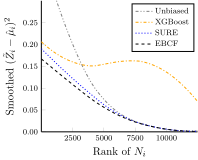

In [39]:
loess_plot = plot(rank_n, loess_preds,
              seriestype=:line,
              xlim=(0.5,length(ss)),
              ylim=(0,0.3),
              color = ["grey" "orange" "blue" "black"],
              linestyle = [:dashdotdot :dashdot :dot :dash],
              label=["Unbiased" "XGBoost" "SURE" "EBCF"],
              xlab=L"Rank of $N_i$",
              ylab=L"Smoothed $(\tilde{Z}_i - \hat{\mu}_i)^2$",
              grid=false)
loess_plot

In [32]:
# savefig(loess_plot, "loess_plot.pdf")

## Plot predictions for Horror-Scifi movies

Here, for each Horror+Scifi movie, we plot the difference between the different $\hat{\mu}$'s (and the true $\mu$s) and the unbiased estimator. We plot this against `rank_n`.

In [33]:
sure_minus_unbiased = sure_preds .- unbiased_preds
ebcf_minus_unbiased = ebcf_preds .- unbiased_preds
truth_minus_unbiased = ground_truth .- unbiased_preds
est_minus_unbiased = hcat(ebcf_minus_unbiased, 
                          sure_minus_unbiased,
                          truth_minus_unbiased);

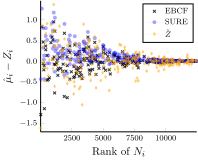

In [34]:
horrorscifi_plot_manuscript = plot(rank_n[horror_plus_scifi_idx],
               est_minus_unbiased[horror_plus_scifi_idx,:],
               seriestype=:scatter, alpha=[0.35 0.35 0.55], markershape=[:xcross :circle :diamond],
               color=["grey" "blue" "orange"],
                xlim=(0.001,length(ss)),
                label=["EBCF" "SURE" L"\tilde{Z}"],
                ylabel=L"\hat{\mu}_i - Z_i",
                xlab=L"Rank of $N_i$",
                markerstrokealpha=[0.8 0 0],
                grid=false)

In [35]:
#savefig(horrorscifi_plot_manuscript, "horrorscifi_plot_manuscript.pdf")

Also repeat above plot without showing true $\mu$s:

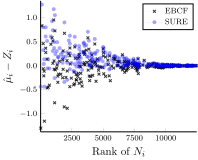

In [36]:
horrorscifi_plot_talks = plot(rank_n[horror_plus_scifi_idx],
     [ebcf_minus_unbiased[horror_plus_scifi_idx] sure_minus_unbiased[horror_plus_scifi_idx]],
       seriestype=:scatter, alpha=0.35, markershape=[:xcross :circle],
       color=["grey" "blue"],
        xlim=(0.5,length(ss)),
        label=["EBCF" "SURE"],
        ylabel=L"\hat{\mu}_i - Z_i",
        xlab=L"Rank of $N_i$",
        markerstrokealpha=[0.8 0],
        grid=false)

In [37]:
#savefig(horrorscifi_plot_talks, "horrorscifi_plot_talks.pdf")